## Семинар 5. Стационарность. Белый шум. MA-процесс.

##### Стационарность

Для начала кратко повторим, что такое стационарность. $y_t$ называется слабо стационарным процессом, если:

$$E[y_t] = \mu$$

$$cov(y_t, y_{t-k}) = \gamma_k$$

Мы уже мельком говорили, что стационарные процессы нам интересны по причине простоты в их прогнозировании. И действительно, чем меньше характеристик процесса изменяется со временем, тем проще построить прогноз. А ещё мы задёшево можем сводить нестационарные ряды к стационарным (ну или почти стационарными). 

На лекции вам уже приводили теорему Вольда и рассказали, что можно разложить слабо стационарный процесс на прогнозируемую часть и MA($\infty$)-процесс. Однако для того, чтобы определить MA-процесс, нужно поговорить о вспомогательном объекте: процессе белого шума (White Noise)

##### Процесс белого шума

Процес белого шума сам по себе является частным случаем стационарного ряда. 

$$E[y_t] = 0$$

$$Var[y_t] = \sigma^2$$

$$cov(y_t, y_{t-k}) = 0 \ \forall \ k \neq 0$$


Попробуем сгенерировать самый простой случай белого шума -- последовательность iid N(0,1) случайных величин.

In [36]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from scipy.stats import norm, chi2 
from sktime.utils.plotting import plot_correlations


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)


<AxesSubplot:title={'center':'White Noise process'}, xlabel='Time'>

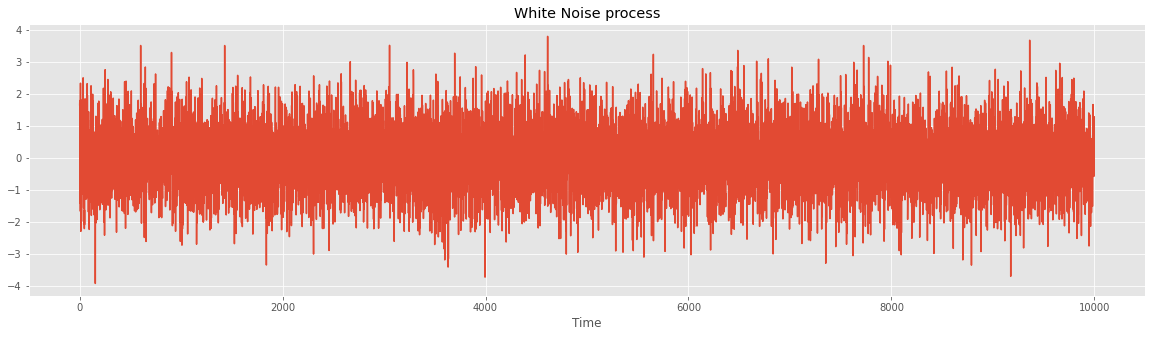

In [11]:
n_obs = 10000
sample = pd.Series(np.random.normal(size=n_obs))

plt.title('White Noise process')
plt.xlabel('Time')
sample.plot()

Попробуем проверить, действительно ли выполняются на таком временном ряде условия белого шума. Начнём с оценки математического ожидания. Построим самую простую оценку -- среднее.

In [19]:



mu_hat = np.mean(sample)
mu_hat



-0.006888985093629165

In [20]:
# p-value гипотезы о равенстве среднего нулю
2 * norm.cdf(mu_hat * np.sqrt(n_obs) / np.std(sample)) 


0.4884953629084652

Проверим дисперсию на разных участках.

In [21]:
# На левом
np.std(sample.head(300))

1.046558581024326

In [23]:
# На правом
np.std(sample.tail(300))

0.9433145790619009

Проверим автокорреляции. Видим, что значимых автокорреляций не наблюдается. Однако метод "на глазок" нас всё же не устраивает, мы же учёные. Для тестирования процесса на наличие значимых автокорреляций (а значит, по факту, на белошумность) используют Portmanteau тесты. И нет, это не фамилия учёного, это просто название типа теста.

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

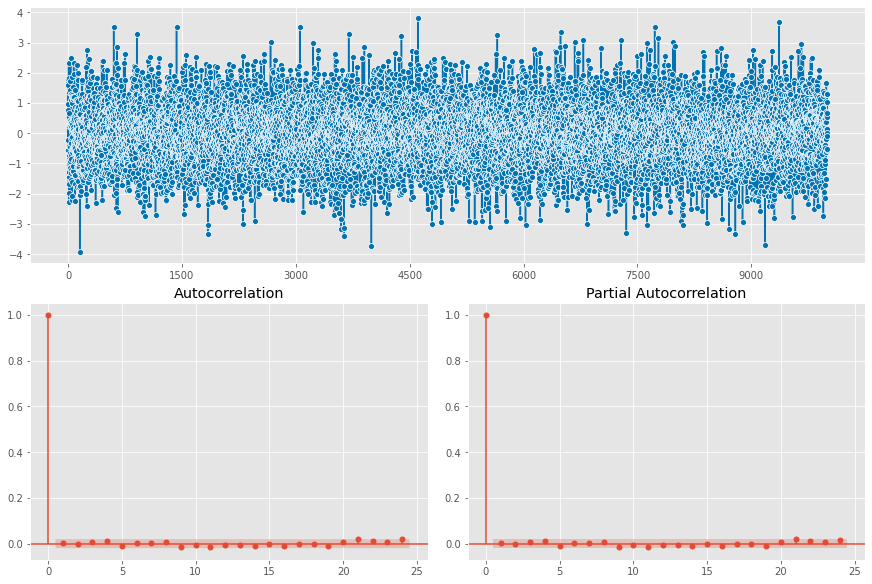

In [25]:
plot_correlations(sample)

С этими тестами в Питоне всё не очень хорошо. Они есть, но они завязаны на использование пакета Statsmodels. Однако в целом они несложно реализуются. Попробуем написать самый банальный: тест Box-Pierce:

$$H_0: \hat{\rho}_1 = \cdots = \hat{\rho}_m = 0$$
$$H_A: \exists \hat{\rho}_i \neq 0$$

$$Q(m) = T \sum_{l=1}^m \hat{\rho}_l^2 \sim \chi^2_m$$

In [48]:
m = 10
corrs = [np.corrcoef(sample[k:], sample.shift(k)[k:])[0][1] for k in range(1, m+1)]

test_stat = np.sum(np.square(corrs)) * n_obs

In [49]:
# p-value
1-chi2.cdf(test_stat, 10)


0.8756111076786529

Есть и более совершенные тесты. Например, тест Льюнга-Бокса. Хотя на самом деле такой перевод словосочетания Ljung-Box не совсем корректен, ведь Грета Льюнг была женщиной и склонение выбрано заведомо неправильно. Статистика этого теста на малых выборках ближе к хи-квадрат распределению чем статистика Бокса-Пирса

$$Q(m) = T(T+2) \sum_{l=1}^m \frac{\hat{\rho}_l^2}{T-1} \sim \chi^2_m$$

In [50]:
test_stat = np.sum(np.square(corrs) / n_obs-1) * n_obs * (n_obs + 2)

# p-value
1-chi2.cdf(test_stat, 10)


1.0

Некоторое время назад мы обсуждали также, что хотелось бы тестировать остатки моделей на наличие автокорреляций. Оказывается, что стандартные тесты не очень для этого подходят. Об этом есть даже некоторый небольшой [тред](https://stats.stackexchange.com/questions/148004/testing-for-autocorrelation-ljung-box-versus-breusch-godfrey), можете почитать, если интересно. Несколько лучше подходит для этих целей тест Бройша-Годфри. Он предполагает, что оценена линейная регрессионная модель и позволяет протестировать остатки такой модели на наличие автокорреляций. Мы попробуем реализовать его в домашке.

##### MA-процесс

Теперь посмотрим повнимательнее на MA-процесс. Как мы уже знаем, для описания стационарного ряда нам необходима модель $MA(\infty)$. Однако, по понятным причинам, оценить её не представляется возможным. Да и не встречается такой острой в этом необходимость. Попробуем поговорить про $MA(k)$-модель. Она выглядит следующим образом:

$$y_t = \mu + \epsilon_t + \alpha_1 \epsilon_{t-1} + \cdots + \alpha_k \epsilon_{t-k}$$

В классических учебниках часто записывается следующая форма:

$$y_t = \mu + \epsilon_t - \alpha_1 \epsilon_{t-1} - \cdots - \alpha_k \epsilon_{t-k}$$

Но понятное дело, что эти формы суть есть одно и то же с точность до знака $\alpha_i$. Мы будем пользоваться первой формулой. В пакетах она более распространена. Попробуем посимулировать и взглянуть на различные MA-процессы.

In [52]:
from statsmodels.api import tsa

Начнём с процесса белого шума, или MA(0):

$$y_t = \mu + \epsilon_t, \ \epsilon_t \sim iid N(0, 1)$$

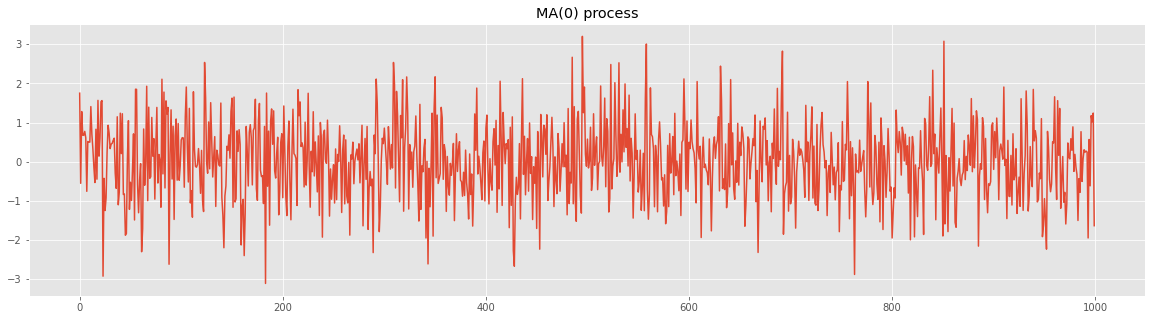

In [68]:
wn_process = tsa.ArmaProcess()
sample = pd.Series(wn_process.generate_sample(nsample=1000, burnin = 1000))
sample.plot()
plt.title('MA(0) process');

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

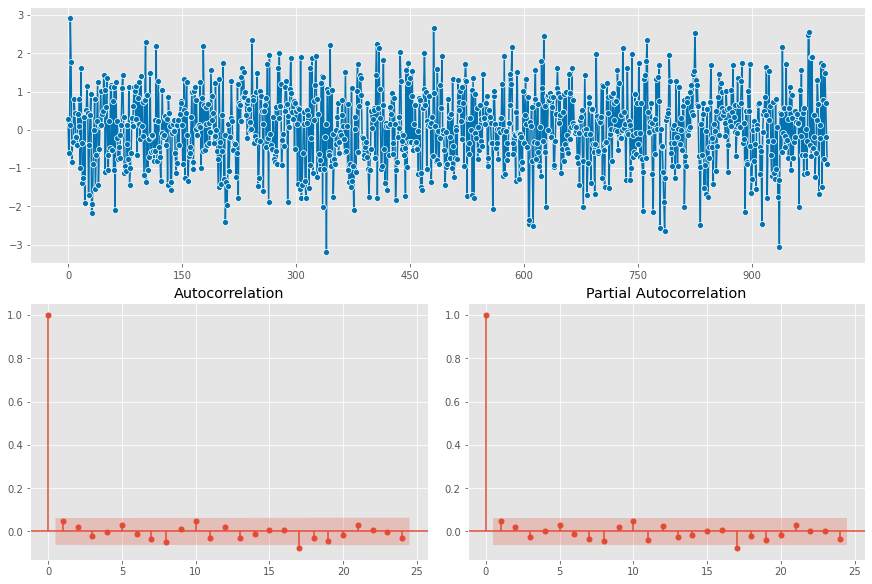

In [62]:
plot_correlations(sample)

Теперь MA(1):

$$y_t = \mu + \epsilon_t + 0.5 \epsilon_{t-1}, \ \epsilon_t \sim iid N(0, 1)$$

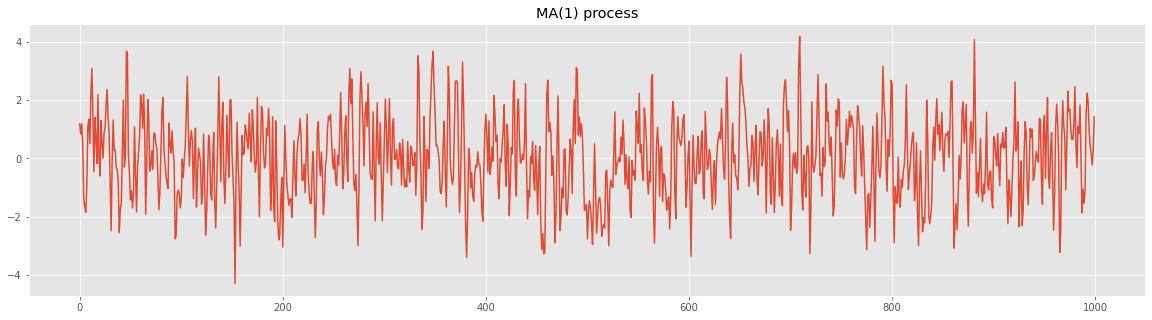

In [69]:
ma_process = tsa.ArmaProcess(ma=[1, 0.9])
sample = pd.Series(ma_process.generate_sample(nsample=1000, burnin = 10000))
sample.plot()
plt.title('MA(1) process');

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

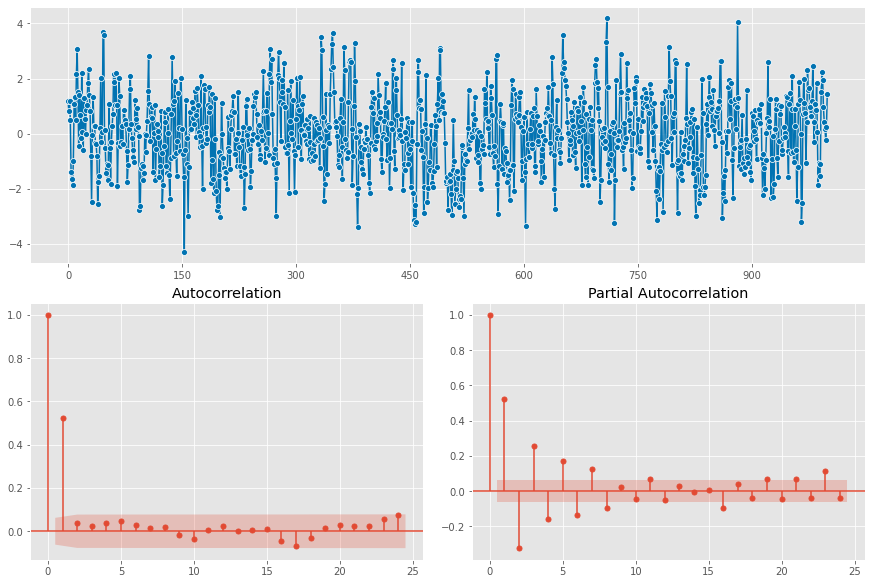

In [70]:
plot_correlations(sample)


MA(5):

$$y_t = \mu + \epsilon_t + 0.9 \epsilon_{t-1} + 0.8 \epsilon_{t-2} + 0.5 \epsilon_{t-3} + 0.6 \epsilon_{t-4} + 0.2 \epsilon_{t-5}, \ \epsilon_t \sim iid N(0, 1)$$

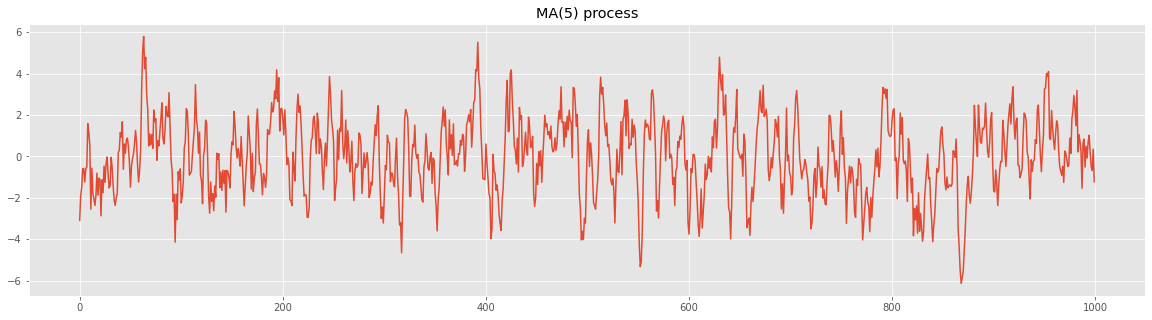

In [79]:
ma_process = tsa.ArmaProcess(ma=[1, 0.9, 0.8, 0.5, 0.6, 0.2])
sample = pd.Series(ma_process.generate_sample(nsample=1000, burnin = 1000))
sample.plot()
plt.title('MA(5) process');

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

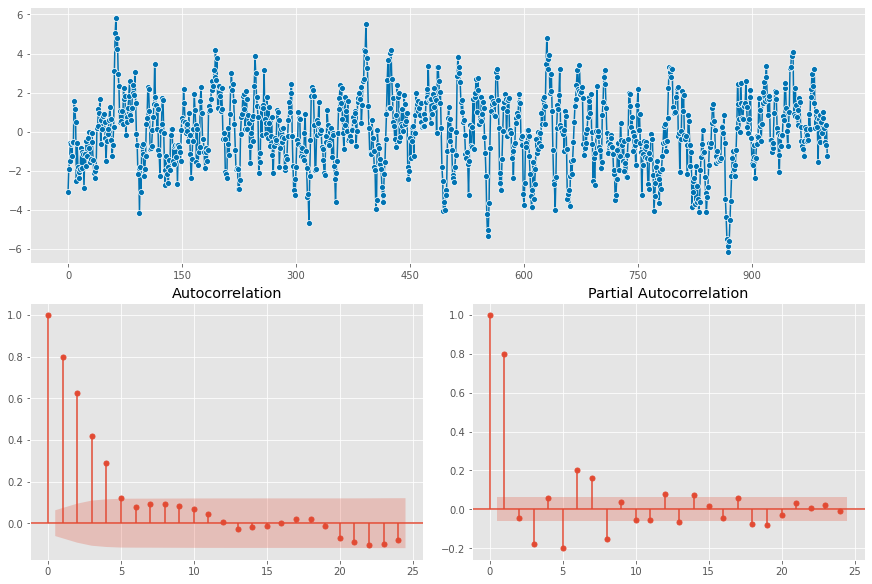

In [80]:
plot_correlations(sample)

Оценим на последнем сэмпле MA(1) модель

In [85]:
from sktime.forecasting.arima import ARIMA


forecaster = ARIMA(order = (0, 0, 1))
forecaster.fit(sample)

resid = forecaster.predict_residuals()
forecaster.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(0, 0, 1)   Log Likelihood               -1734.708
Date:                Mon, 14 Feb 2022   AIC                           3475.416
Time:                        05:36:54   BIC                           3490.139
Sample:                             0   HQIC                          3481.012
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0152      0.068     -0.223      0.824      -0.149       0.119
ma.L1          0.5755      0.027     21.323      0.000       0.523       0.628
sigma2         1.8798      0.085     22.099      0.000       1.713       2.046
===================================================================================
Ljung-Box (L1) (Q):                 128.65   Jarque-Bera (JB):                 0.75
Prob(Q):                              0.00   Prob(JB):                         0.69
Heteroskedasticity (H):               1.07   Skew:                            -0.07
Prob(H) (two-sided):                  0.51   Kurtosis:                         2.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Видим, что присутствуют существенные автокорреляции в остатках

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

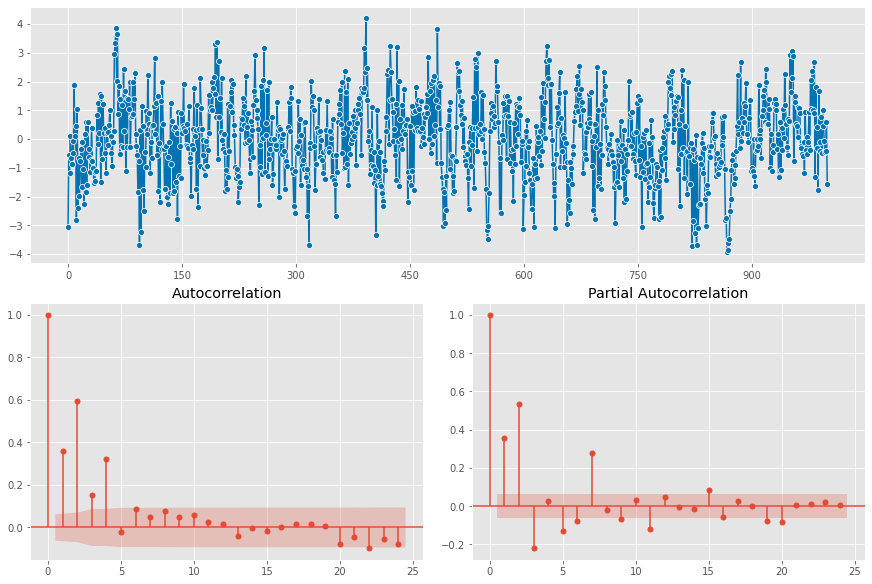

In [82]:
plot_correlations(resid)

Попробуем оценить MA(5)-модель:

In [86]:
forecaster = ARIMA(order = (0, 0, 5))
forecaster.fit(sample)

resid = forecaster.predict_residuals()

In [87]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(0, 0, 5)   Log Likelihood               -1408.508
Date:                Mon, 14 Feb 2022   AIC                           2831.015
Time:                        05:37:21   BIC                           2865.370
Sample:                             0   HQIC                          2844.072
                               - 1000                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0232      0.128     -0.181      0.856      -0.275       0.228
ma.L1          0.9087      0.031     28.853      0.000       0.847       0.970
ma.L2          0.8660      0.037     23.259      0.000       0.793       0.939
ma.L3          0.5458      0.045     12.116      0.000       0.457       0.634
ma.L4          0.6295      0.038     16.700      0.000       0.556       0.703
ma.L5          0.1745      0.033      5.229      0.000       0.109       0.240
sigma2         0.9772      0.045     21.823      0.000       0.889       1.065
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.37
Prob(Q):                              0.93   Prob(JB):                         0.83
Heteroskedasticity (H):               0.98   Skew:                             0.04
Prob(H) (two-sided):                  0.83   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Видим, что существенные автокорреляции почти остутствуют в остатках. Значит, большего линейными моделями уже точно не добиться и мы покрыли всю линеюную динамику данных

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

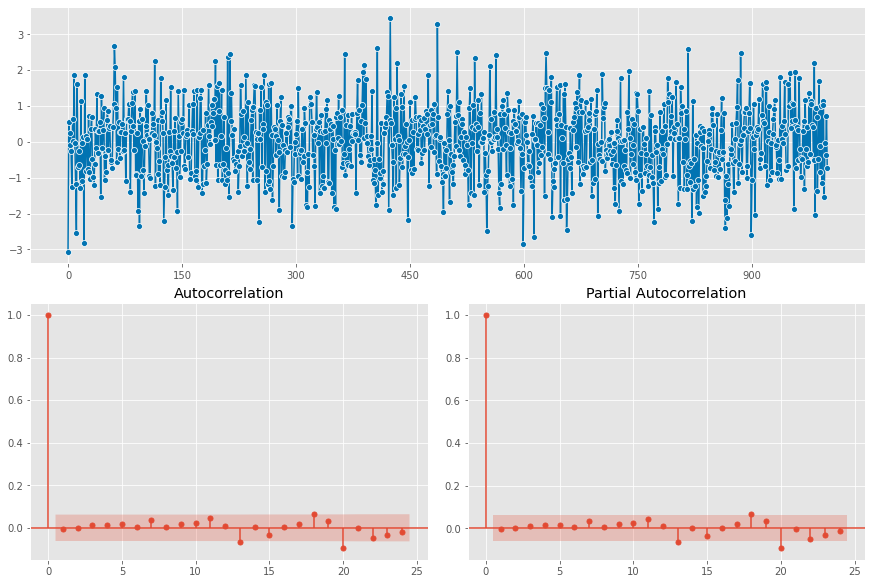

In [88]:
plot_correlations(resid)